<a href="https://colab.research.google.com/github/ggeorgekkariuki/Tensor-Titanic-Dataset/blob/main/TF_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

# import tensorflow.compat.v2.feature_column as fc
from tensorflow import feature_column as fc

import tensorflow as tf

## The Objective

In this tutorial we will use a linear model to predict the survival rate of passangers from the titanic dataset.

The point of our model is to be able to make predictions on NEW data, data that we have never seen before.

### Data

The dataset we will be focusing on here is the titanic dataset. It has tons of information about each passanger on the ship. 

Our first step is always to understand the data and explore it.

In [2]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data and validation data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data

y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

Data Exploration

In [ ]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [ ]:
dftrain.isna().sum()

sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [ ]:
# There are no missing data points

In [ ]:
dftrain.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [ ]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


Basic Visualisations

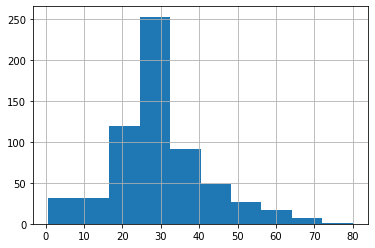

In [ ]:
dftrain.age.hist(bins=10)

Most passengers were in range 20 and 30

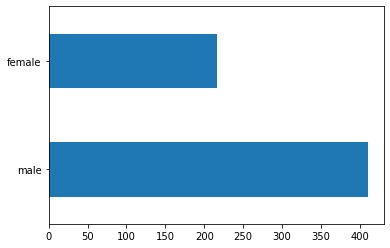

In [ ]:
dftrain.sex.value_counts().plot(kind='barh')

There were more men that there were women

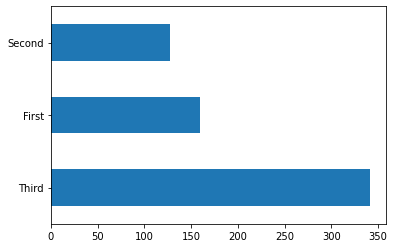

In [ ]:
dftrain['class'].value_counts().plot(kind='barh')

Most of the passengers were in the Third Class, second largest class was the First class and the least population class was the Second Class

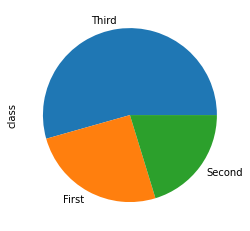

In [ ]:
dftrain['class'].value_counts().plot(kind='pie')

Text(0.5, 0, '% survived')

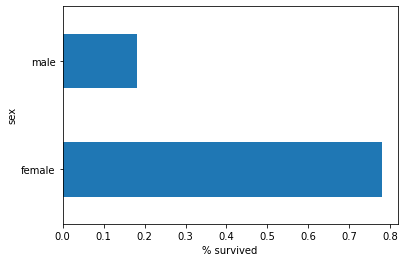

In [ ]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

A larger % of women survived than men did.

### Training vs Testing Data

### Feature Columns

In our dataset we have two different kinds of information: Categorical and Numeric

Our categorical data is anything that is not numeric! For example, the sex column does not use numbers, it uses the words "male" and "female".

Before we continue and create/train a model we must convert our categorical data into numeric data. We can do this by encoding each category with an integer (ex. male = 1, female = 2).

We create an object - a tensor object - that our model can use to map string values like "male" and "female" to integers. This allows us to avoid manually having to encode our dataframes.

In [ ]:
dftrain.columns

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

In [3]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses','parch', 'class', 'deck',
       'embark_town', 'alone']
NUMERICAL_COLUMNS = ['age', 'fare']

feature_columns = []

for c in CATEGORICAL_COLUMNS:
  # gets a list of all unique values from given feature column
  vocabulary = dftrain[c].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(key=c, vocabulary_list=vocabulary))

for n in NUMERICAL_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(key=n, dtype=tf.float32))

In [ ]:
for i in feature_columns:
  print(i)

VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_va

In [ ]:
f = []
val = dftrain['class'].unique()
f.append(tf.feature_column.categorical_column_with_vocabulary_list('class', val ))
f

[VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)]

### Trainng

For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We will feed these batches to our model multiple times according to the number of epochs.

An epoch is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Ex. if we have 10 ephocs, our model will see the same dataset 10 times.

Since we need to feed our data in batches and multiple times, we need to create something called an input function. The input function simply defines how our dataset will be converted into batches at each epoch.

#### The Input Function

The TensorFlow model we are going to use requires that the data we pass it comes in as a *tf.data.Dataset object*. This means we must create a input function that can convert our current pandas dataframe into that object.

In [11]:
def make_input_fn(data_df, label_df, num_epoch=10, shuffle=True, batch_size=32):
  def input_function():
    """
    converts our current pandas dataframe into that tf.data.Dataset
    """
    # Create a source dataset from your input data.
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds.shuffle(1000) # randomize order of data
    # split dataset into batches of 32
    # Repeats this dataset so each original value is seen for the number of epochs
    ds = ds.batch(batch_size).repeat(num_epoch)

    return ds

  return input_function

In [12]:
# Creating the input functions for the Training and Testing Data
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, num_epoch=1)

### Creating the Model

we are going to use a linear estimator to utilize the linear regression algorithm.

In [9]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmug2tjj2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Training and Evaluating the Model



In [13]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.7613636


### Prediction

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmug2tjj2/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


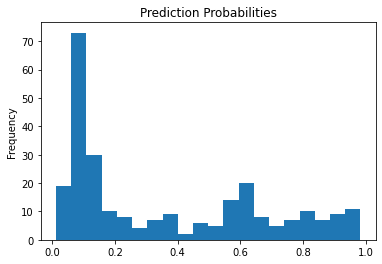

In [15]:
pred_dict = list(linear_est.predict(eval_input_fn))

probs = pd.Series([preds['probabilities'][1] for preds in pred_dict])

probs.plot(kind='hist', bins=20, title='Prediction Probabilities')